<div align="right">Enseignant : Roman Yurchak</div>
<div align="right">Réalisé par : Eunice KOFFI et DIAKITE Gaoussou</div>

<img src="https://i0.wp.com/mosefparis1.fr/wp-content/uploads/2022/10/cropped-image-1.png?w=532&ssl=1" width=90px align="left">
<hr style="border-width:4px;border-color:#75DFC1">
<center><h1>Projet Deep Learning</h1></center>
<center><h2>Master 2 Modélisations Statistiques Économiques et Financières</h2></center>
<center><h2>Université Paris 1 Panthéon-Sorbonne</h2></center>
<hr style="border-width:4px;border-color:#75DFC1">
La classification d'âge à partir d'images de personnes est un problème de vision par ordinateur qui a de nombreuses applications pratiques, telles que la publicité ciblée, la sécurité, la reconnaissance faciale, etc. Elle permet également aux experts de prédire les caractéristiques des populations et de comprendre les tendances démographiques. Dans ce projet, nous allons explorer différentes approches de Deep Learning pour entraîner un modèle capable de classifier les images de personnes selon leur âge.

Nous allons tout d'abord prétraiter les images en utilisant différentes techniques telles que la normalisation, la redimensionnement, le recadrage, etc. Ensuite, nous allons entraîner et évaluer le modèle à l'aide de différentes architectures de réseaux de neurones, telles que les réseaux de neurones convolutionnels (CNN), le ResNet, l'InceptionResNet. Nous allons utiliser l'accuracy pour évaluer la qualité de notre modèle.

Enfin, nous allons discuter des résultats et des limites du modèle, et proposer des perspectives d'amélioration pour de futures recherches dans ce domaine.


><div class="alert alert-block alert-success">
><b>Objectif :</b> Dans ce projet, nous serons amenés à travailler sur un ensemble de données d'images de personnes de différents âges. L'objectif sera de créer un modèle de classification capable de prédire si une personne est jeune, d'âge moyen ou âgée à partir de son image.

</div>
<br/><br/>

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:20px;color:darkgreen"> <span style="color:green">      
Librairies</span>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import os
import seaborn as sns 
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from tensorflow.keras import layers,models

import os
import random
from PIL import Image
import numpy as np


import warnings
warnings.filterwarnings("ignore")


<hr style="border-width:2px;border-color:#75DFC1">
<center><h2>Lecture de la base de données </h2></center>
<hr style="border-width:2px;border-color:#75DFC1">

In [2]:
# Charger le fichier CSV contenant les ID des images et leurs classes
df = pd.read_csv("Data/train.csv")
df.shape

(19906, 2)

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:16px">
Au départ, nous disposions d'un seul fichier qui contenait 19906 images. Nous allons faire un split de ces images en les rangeant dans différents dossiers suivant cette architecture
    
- Dossier
- Train ou test ou val
- un dossier par classe OLD, YOUNG, MIDDLE
    
</span></div>

In [3]:
df.head()

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [4]:
df['Class'].value_counts()

MIDDLE    10804
YOUNG      6706
OLD        2396
Name: Class, dtype: int64

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:16px">
Le jeu de données a été collecté sur Kaggle. Il comprend des images de personnes de différents âges et leur classe d'âge correspondante : jeune, d'âge moyen ou âgé. La base de données contient 10804 images pour la classe d'âge "d'âge moyen", 6706 images pour la classe d'âge "jeune" et 2396 images pour la classe d'âge "âgé".
</span></div>




<hr style="border-width:2px;border-color:#75DFC1">
<center><h2>Visualisation</h2></center>
<hr style="border-width:2px;border-color:#75DFC1">

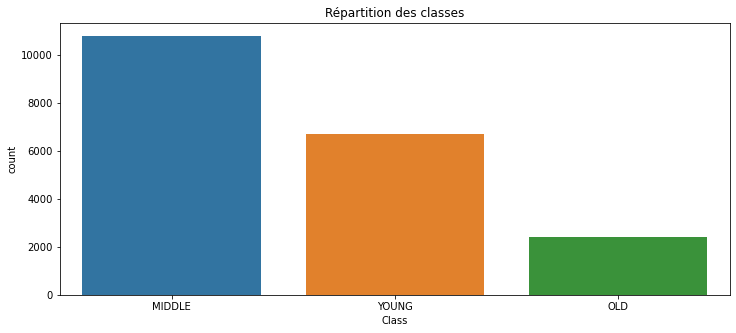

In [5]:
plt.figure(figsize=(12,5))
sns.countplot(x='Class', data=df)
plt.title("Répartition des classes")
plt.show()

In [6]:
def view_random_images(target_dir, target_class):
    target_folder = target_dir+target_class
    random_images = random.sample(os.listdir(target_folder), 5)
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(16,10))
    for i, image_name in enumerate(random_images):
        img = mpimg.imread(target_folder + "/" + image_name)
        axes[i].imshow(img)
        axes[i].set_title(target_class)
        axes[i].axis("off")
        #print(f"Image {i+1} shape: {img.shape}")  
    plt.show()

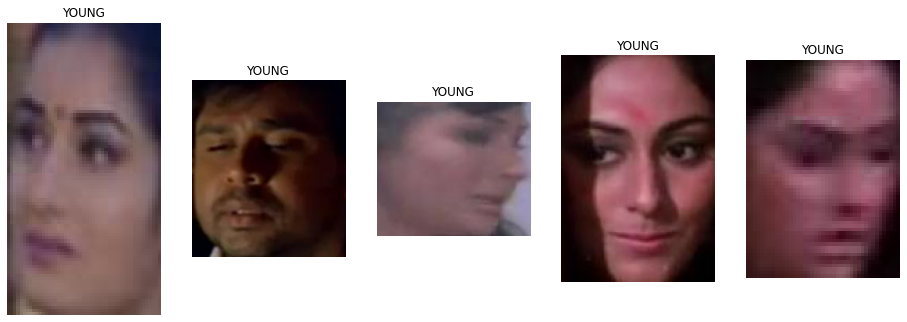

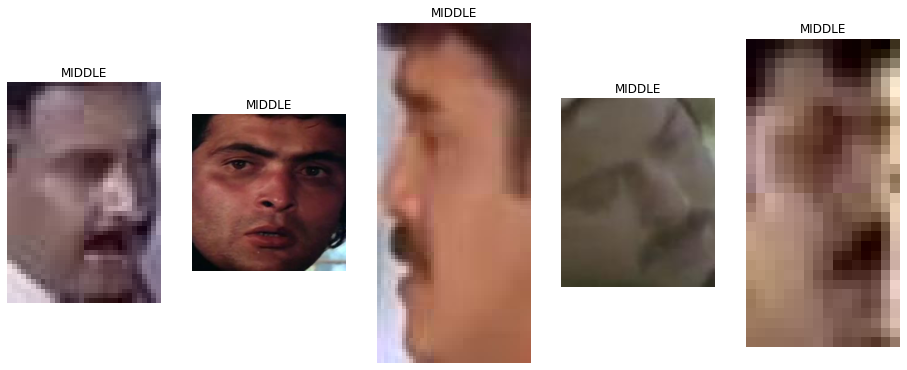

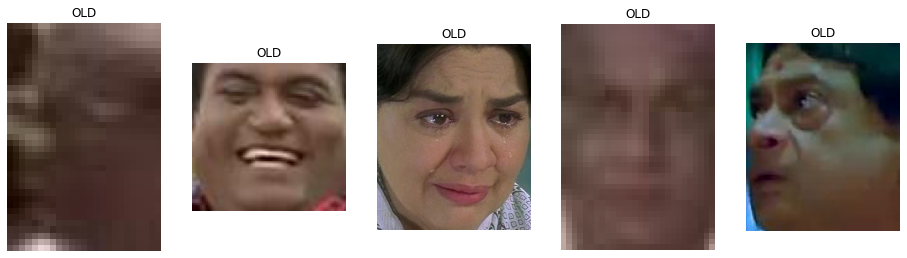

In [7]:
view_random_images(target_dir="Split_data/train/",target_class="YOUNG")
view_random_images(target_dir="Split_data/train/",target_class="MIDDLE")
view_random_images(target_dir="Split_data/train/",target_class="OLD")


<hr style="border-width:2px;border-color:#75DFC1">
<center><h2>Preprocessing</h2></center>
<hr style="border-width:2px;border-color:#75DFC1">

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:16px">
Nous constatons que les images n'ont pas toutes les mêmes dimensions. Nous allons donc les mettre aux mêmes dimensions et faire un générateur d'images pour éviter l'overfitting.

Aussi, la qualité des images n'est pas bonne. En effet, les images ne sont pas nettes, elles ne sont pas toutes prises avec un bon profil et sur certaines les visages ne sont pas bien visibles.

On ne s'attend donc pas à que les modèles construits nous donnent un accuracy de 100% au quel cas cela traduirait de l'overffitting.
</span></div>

In [8]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        zoom_range=0.2, # zoom aléatoire de 20%
        rotation_range = 20, # rotation aléatoire de 20 degrés
        width_shift_range=0.2, # décalage horizontal aléatoire de 20% de la largeur de l'image
        height_shift_range=0.2, # décalage vertical aléatoire de 20% de la hauteur de l'image
        horizontal_flip=True, # retournement horizontal aléatoire
        fill_mode='nearest') # remplir les pixels manquants avec les pixels les plus proches

test_val_datagen = ImageDataGenerator(rescale = 1./255)

In [9]:
training_set = train_datagen.flow_from_directory("Split_data/train",
                                        target_size = (224, 224), 
                                        batch_size = 32, 
                                        class_mode = 'categorical')

Found 15923 images belonging to 3 classes.


In [10]:
test_set = test_val_datagen.flow_from_directory("Split_data/test", 
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        class_mode = 'categorical')

Found 1994 images belonging to 3 classes.


In [11]:
val_set = test_val_datagen.flow_from_directory("Split_data/val", 
                                        target_size = (224, 224),
                                        batch_size = 32,
                                        class_mode = 'categorical')

Found 1989 images belonging to 3 classes.


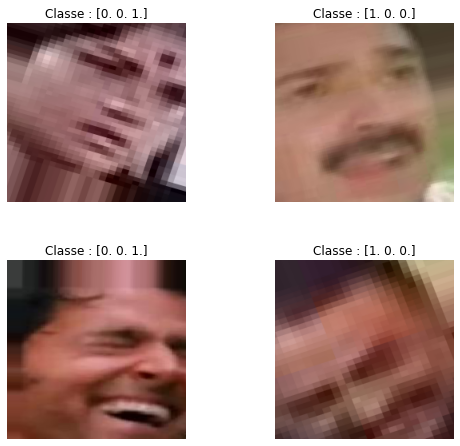

In [12]:
# Obtenez un lot d'images et de labels
images, labels = training_set.next()

# Affichez les 4 premières images du lot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
axes = axes.ravel()
for i in range(4):
    axes[i].imshow(images[i])
    axes[i].set_title("Classe : {}".format(labels[i]))
    axes[i].axis('off')
plt.subplots_adjust(wspace=0.5)
plt.show()


<hr style="border-width:2px;border-color:#75DFC1">
<center><h2>Modèles </h2></center>
<hr style="border-width:2px;border-color:#75DFC1">

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:16px">
Dans cette section, nous allons présenter les trois modèles de réseaux de neurones que nous avons utilisés pour la classification d'âge à partir d'images de personnes : CNN, ResNet, et InceptionResNetV2. Nous allons décrire chaque modèle et ses avantages, et intégrer les équations mathématiques correspondantes.
</span></div>



In [13]:
def plot_history(history):
    # store results
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # plot results
    # accuracy
    plt.figure(figsize=(12, 5))
    plt.rcParams['figure.figsize'] = [8, 4]
    plt.rcParams['font.size'] = 10
    plt.rcParams['axes.grid'] = True
    plt.rcParams['figure.facecolor'] = 'white'
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')
    
    
    # loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
    plt.xlabel('epoch')
    plt.tight_layout(pad=3.0)
    plt.show()


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px;color:darkgreen"> <span style="color:green">1. CNN</span>

In [14]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model_history2 = model.fit(training_set, epochs=10, validation_data=test_set)

model.evaluate(val_set)

Epoch 1/10
498/498 [==============================] - 1017s 2s/step - loss: 2.7576 - accuracy: 0.5339 - val_loss: 0.8869 - val_accuracy: 0.6018
Epoch 2/10
498/498 [==============================] - 908s 2s/step - loss: 0.8643 - accuracy: 0.6070 - val_loss: 0.8230 - val_accuracy: 0.6304
Epoch 3/10
498/498 [==============================] - 889s 2s/step - loss: 0.8414 - accuracy: 0.6148 - val_loss: 0.8276 - val_accuracy: 0.6284
Epoch 4/10
498/498 [==============================] - 851s 2s/step - loss: 0.8388 - accuracy: 0.6181 - val_loss: 0.8136 - val_accuracy: 0.6314
Epoch 5/10
498/498 [==============================] - 843s 2s/step - loss: 0.8220 - accuracy: 0.6247 - val_loss: 0.7740 - val_accuracy: 0.6510
Epoch 6/10
498/498 [==============================] - 829s 2s/step - loss: 0.8169 - accuracy: 0.6254 - val_loss: 0.9366 - val_accuracy: 0.6068
Epoch 7/10
498/498 [==============================] - 850s 2s/step - loss: 0.8104 - accuracy: 0.6284 - val_loss: 0.7990 - val_accuracy: 0.637

[0.7517420649528503, 0.6857717633247375]

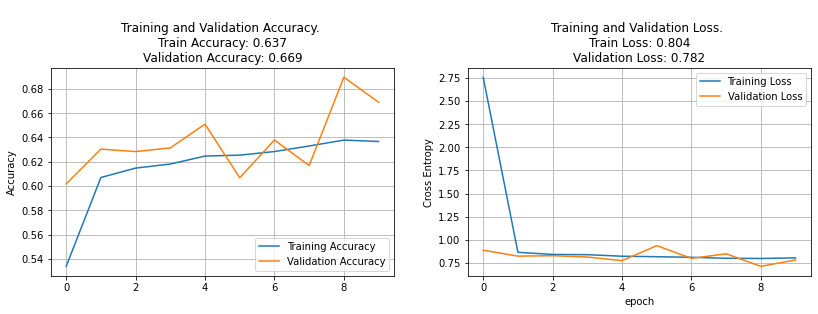

In [33]:
plot_history(model_history2)


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px;color:darkgreen"> <span style="color:green">2. CNN</span>

In [17]:
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(256, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())

model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model_history4 = model2.fit(training_set, epochs=10, validation_data=test_set)

Epoch 1/10
498/498 [==============================] - 839s 2s/step - loss: 0.9181 - accuracy: 0.5631 - val_loss: 0.8828 - val_accuracy: 0.5928
Epoch 2/10
498/498 [==============================] - 834s 2s/step - loss: 0.8683 - accuracy: 0.5984 - val_loss: 0.8409 - val_accuracy: 0.6344
Epoch 3/10
498/498 [==============================] - 833s 2s/step - loss: 0.8467 - accuracy: 0.6173 - val_loss: 0.7717 - val_accuracy: 0.6525
Epoch 4/10
498/498 [==============================] - 830s 2s/step - loss: 0.8230 - accuracy: 0.6317 - val_loss: 0.7776 - val_accuracy: 0.6565
Epoch 5/10
498/498 [==============================] - 844s 2s/step - loss: 0.8004 - accuracy: 0.6408 - val_loss: 0.7348 - val_accuracy: 0.6740
Epoch 6/10
498/498 [==============================] - 813s 2s/step - loss: 0.7851 - accuracy: 0.6464 - val_loss: 0.7097 - val_accuracy: 0.6846
Epoch 7/10
498/498 [==============================] - 819s 2s/step - loss: 0.7617 - accuracy: 0.6660 - val_loss: 0.6909 - val_accuracy: 0.7066

In [21]:
model2.evaluate(val_set)

63/63 [==============================] - 28s 441ms/step - loss: 0.6653 - accuracy: 0.7119


[0.6652719974517822, 0.7119155526161194]

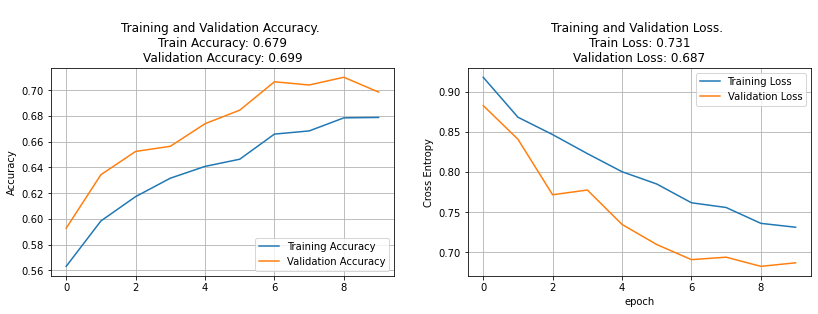

In [34]:
plot_history(model_history4)


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px;color:darkgreen"> <span style="color:green">2. ResNET</span>

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:16px">
Le modèle ResNet est un modèle préentrainé qui est bien performant pour le traitement des images. Nous allons donc l'utiliser. Cependant, nous allons modifier la sortie du modèle afin de l'adapter à notre problématique. 
    
Ainsi, en rajoutant les couches BatchNormalization et Dropout, nous intégrons une régularisation en réduisant les paramètres et ainsi réduire les risques d'overfitting.
</span></div>

In [22]:
model_res_init = tf.keras.applications.ResNet50V2(
    input_shape=(224,224,3),
    include_top=False,
)
model_res_init.trainable = False

In [23]:
model_res_init.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [24]:
from tensorflow.keras import layers,models
resnet_model = models.Sequential([
    model_res_init,
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               25690368  
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

In [25]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=1e-4)
resnet_model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

In [26]:
resnet_history = resnet_model.fit(training_set, epochs=10, validation_data=test_set)

Epoch 1/10
498/498 [==============================] - 1271s 3s/step - loss: 1.3731 - accuracy: 0.5287 - val_loss: 0.9286 - val_accuracy: 0.6379
Epoch 2/10
498/498 [==============================] - 1276s 3s/step - loss: 1.0604 - accuracy: 0.5929 - val_loss: 0.7817 - val_accuracy: 0.6966
Epoch 3/10
498/498 [==============================] - 1293s 3s/step - loss: 0.9384 - accuracy: 0.6285 - val_loss: 0.7394 - val_accuracy: 0.7056
Epoch 4/10
498/498 [==============================] - 1272s 3s/step - loss: 0.8899 - accuracy: 0.6400 - val_loss: 0.6895 - val_accuracy: 0.7262
Epoch 5/10
498/498 [==============================] - 1270s 3s/step - loss: 0.8365 - accuracy: 0.6525 - val_loss: 0.6615 - val_accuracy: 0.7322
Epoch 6/10
498/498 [==============================] - 1265s 3s/step - loss: 0.7962 - accuracy: 0.6731 - val_loss: 0.6350 - val_accuracy: 0.7487
Epoch 7/10
498/498 [==============================] - 1301s 3s/step - loss: 0.7760 - accuracy: 0.6753 - val_loss: 0.6598 - val_accuracy:

In [28]:
resnet_model.evaluate(val_set)

63/63 [==============================] - 132s 2s/step - loss: 0.6126 - accuracy: 0.7381


[0.6126329898834229, 0.7380593419075012]

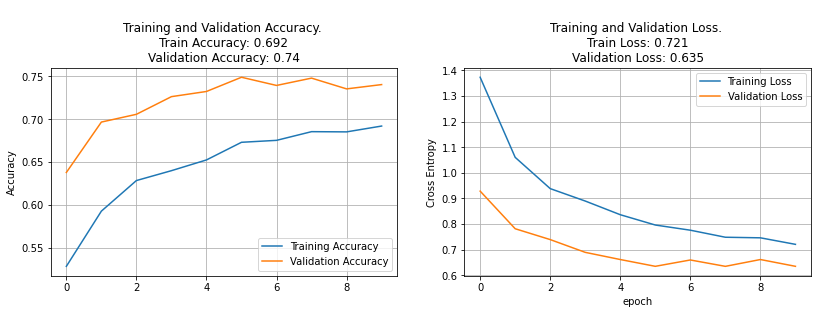

In [35]:
plot_history(resnet_history)


<div align="left"><span style="font-family:Lucida Caligraphy;font-size:35px;color:darkgreen"> <span style="color:green">3. Inception</span>

In [31]:
inception_base_model = tf.keras.applications.InceptionResNetV2(
                     include_top = False,
                     weights = 'imagenet',
                     input_shape = (224, 224, 3)
                     )

inception_model = models.Sequential([
    inception_base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.4),
    layers.Dense(64, activation = 'relu'),
    layers.Dropout(0.2),
    layers.Dense(3, activation='softmax')
])

inception_model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

inception_history = inception_model.fit(training_set, epochs=15, validation_data=test_set)

Epoch 1/15
498/498 [==============================] - 11344s 23s/step - loss: 0.7433 - accuracy: 0.6822 - val_loss: 0.5697 - val_accuracy: 0.7768
Epoch 2/15
498/498 [==============================] - 9874s 20s/step - loss: 0.5730 - accuracy: 0.7631 - val_loss: 0.4699 - val_accuracy: 0.8205
Epoch 3/15
498/498 [==============================] - 9251s 19s/step - loss: 0.4826 - accuracy: 0.8066 - val_loss: 0.5167 - val_accuracy: 0.8049
Epoch 4/15
498/498 [==============================] - 9113s 18s/step - loss: 0.4134 - accuracy: 0.8370 - val_loss: 0.4050 - val_accuracy: 0.8390
Epoch 5/15
498/498 [==============================] - 9102s 18s/step - loss: 0.3612 - accuracy: 0.8613 - val_loss: 0.3813 - val_accuracy: 0.8591
Epoch 6/15
498/498 [==============================] - 9144s 18s/step - loss: 0.3135 - accuracy: 0.8822 - val_loss: 0.3456 - val_accuracy: 0.8726
Epoch 7/15
498/498 [==============================] - 8985s 18s/step - loss: 0.2713 - accuracy: 0.8972 - val_loss: 0.3127 - val_a

In [32]:
inception_model.evaluate(val_set)

63/63 [==============================] - 244s 4s/step - loss: 0.4281 - accuracy: 0.8688


[0.42811065912246704, 0.8687782883644104]

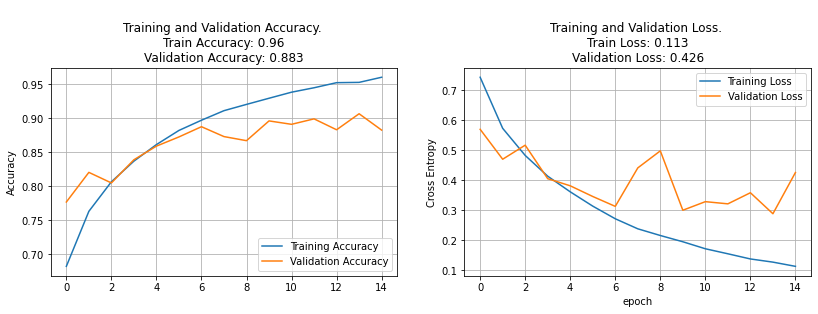

In [36]:
plot_history(inception_history)


<hr style="border-width:2px;border-color:#75DFC1">
<center><h2>Conclusion </h2></center>
<hr style="border-width:2px;border-color:#75DFC1">

<div align="left"><span style="font-family:Lucida Caligraphy;font-size:16px">
Dans ce projet de classification d'âge à partir d'images de personnes, nous avons exploré différentes approches de Deep Learning pour entraîner notre modèle. Nous avons prétraité les images en utilisant différentes techniques telles que la normalisation, le recadrage et les transformations aléatoires. Nous avons évalué la qualité de notre modèle en utilisant l'accuracy et avons comparé les performances de différentes architectures de réseaux de neurones, notamment les réseaux de neurones convolutionnels (CNN), le ResNet et l'InceptionResNet.

Après évaluation, nous avons choisi de garder l'architecture de ResNet pour notre modèle de classification, car elle a donné les meilleurs résultats en termes d'accuracy. Nous avons également discuté des résultats et des limites de notre modèle, et avons proposé des perspectives d'amélioration pour de futures recherches dans ce domaine.

En somme, ce projet nous a permis de mieux comprendre le processus de classification d'âge à partir d'images de personnes et les différentes techniques de prétraitement des images. Il a également mis en évidence l'importance de choisir la bonne architecture de réseau de neurones pour obtenir les meilleurs résultats possibles.
</span></div>